# A closer look at the practice of Data Augmentation

First, some preparation (import and data loading)

In [1]:
%matplotlib inline

# General imports
import matplotlib.pyplot as plt
import pathlib
import skimage
import skimage.transform
import skimage.viewer
import pandas as pd
import numpy as np
import time
import keras.utils.np_utils
from tqdm import tqdm

# Setup to show interactive jupyter widgets
from IPython.display import Image, display
from ipywidgets import interact, fixed
import ipywidgets as widgets
def imgplotList(i,data):
    plt.figure(figsize=(10,10))
    plt.imshow(data[i],interpolation="nearest")
    plt.show()

/home/lale/anaconda3/envs/deep/lib/python3.6/site-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')
/home/lale/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Define where datasets are located
dataset_directory = pathlib.Path("..")/"datasets"/"final split"

# Define which datasets we should consider.
# Each dataset is a directory withing dataset_directory
# and must contain three subdirectories: (c0, c1, c2) for (rock, paper, scissors).
# dnames = ["testing.small","Dpolimi","D1.small","D2.small","D3.small","D4.small","D5.small","D6.small"]
dnames = ["Dpolimi"]


# Now check the data
ddirs=[dataset_directory/dn for dn in dnames] # directories of the dataset
cdirs={}
for ddir in ddirs:
    cdirs.update({ddir/"c0":0,
                  ddir/"c1":1,
                  ddir/"c2":2})
names = ["rock", "paper", "scissors"]
for cdir,cdir_class in cdirs.items():
    assert(cdir.exists())
    print("Found directory {} containing class {}".format(cdir,names[cdir_class]))

Found directory ../datasets/final split/Dpolimi/c0 containing class rock
Found directory ../datasets/final split/Dpolimi/c1 containing class paper
Found directory ../datasets/final split/Dpolimi/c2 containing class scissors


In [3]:
imagesize = 200

dataset=[]

import warnings

for cdir,cn in tqdm(list(cdirs.items())):
    for f in list(cdir.glob("*")):
        try:
            im=skimage.io.imread(f)
        except (OSError, ValueError) as e:
            warnings.warn("ignoring {} due to exception {}".format(f,str(e)))
            continue
            
        h,w=im.shape[0:2] # height, width
        sz=min(h,w)
        im=im[(h//2-sz//2):(h//2+sz//2),(w//2-sz//2):(w//2+sz//2),:] # defines the central square        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            im=skimage.img_as_ubyte(skimage.transform.resize(im,(imagesize,imagesize))) # resize it to 500x500, whatever the original resolution
            
        dataset.append({
            "file":f,
            "label":cn,
            "image":im})
        
print("Done")

  0%|          | 0/3 [00:00<?, ?it/s]/home/lale/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: ignoring ../datasets/final split/Dpolimi/c0/.DS_Store due to exception cannot identify image file '/home/lale/Desktop/nndemo/rock-paper-scissors/datasets/final split/Dpolimi/c0/.DS_Store'
  if sys.path[0] == '':
 33%|███▎      | 1/3 [00:03<00:06,  3.16s/it]/home/lale/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: ignoring ../datasets/final split/Dpolimi/c1/.DS_Store due to exception cannot identify image file '/home/lale/Desktop/nndemo/rock-paper-scissors/datasets/final split/Dpolimi/c1/.DS_Store'
  if sys.path[0] == '':
 67%|██████▋   | 2/3 [00:06<00:03,  3.19s/it]/home/lale/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: ignoring ../datasets/final split/Dpolimi/c2/.DS_Store due to exception cannot identify image file '/home/lale/Desktop/nndemo/rock-paper-scissors/datasets/f

Done


We make a pandas dataframe for the dataset, and create a "dn" field containing the name of the dataset from which each image comes (as the name of the directory it was read from).

In [4]:
dataset=pd.DataFrame(dataset)
dataset["dn"]=dataset["file"].apply(lambda x: x.parent.parts[-2])

## A closer look to the practice of data augmentation

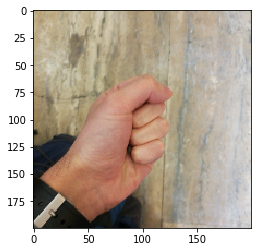

In [5]:
im = list(dataset.sample(1)["image"])[0]
plt.imshow(im)

In [7]:
ims = list(dataset.sample(3)["image"])

In [17]:
def prepare(im, sz, normalize, rot):
    imr = skimage.img_as_float(im)
    imr = skimage.transform.resize(imr, (sz,sz))
    imr = np.rot90(imr, k=rot)
    if(normalize):
        imr = 0.5 + (imr - np.mean(imr))/np.std(imr) * 0.2
    imr = np.clip(imr,0,1)
    return imr

@interact(sz=widgets.IntSlider(min=2,max=32),
          normalize = widgets.ToggleButton(),
          rot=widgets.IntSlider(min=0,max=4),
          continuous_update=False)
def f(sz,normalize,rot):
    fig,axs = plt.subplots(ncols=len(ims),figsize=(18,6))
    for im,ax in zip(ims,axs):
        ax.imshow(prepare(im,sz,normalize,rot))
        

interactive(children=(IntSlider(value=2, description='sz', max=32, min=2), ToggleButton(value=False, description='normalize'), IntSlider(value=0, description='rot', max=4), Output()), _dom_classes=('widget-interact',))

## Let's now edit the cell above to make some basic augmentations / preprocessing
First, we visualize the effect of normalization.

Then, we implement:
- resizing
- 90 deg rotations
- flipping

In [ ]:
def transform(im,sz,rot90times,flip,normalize):
    imr = skimage.transform.resize(im,(sz,sz))
    if(flip):
        imr = np.fliplr(imr)
    imr = np.rot90(imr, k=rot90times)
    if(normalize):
        imr = np.clip((imr-np.mean(imr))/np.std(imr) * 0.2 + 0.5,0,1)
    return imr

@interact(sz = widgets.IntSlider(min=1,max=60,value=30),
          rot90times = widgets.IntSlider(min=0,max=4),
          flip = widgets.ToggleButton(),
          normalize = widgets.ToggleButton(),
          continuous_update=False)
def f(sz,rot90times,flip,normalize):
    fig,axs = plt.subplots(ncols=len(ims),figsize=(18,6))
    for im,ax in zip(ims,axs):
        ax.imshow(transform(im,sz,rot90times,flip,normalize))

## Geometric transformations

Geometric transformations on images require to manipulate transformation objects

In [19]:
tf = (skimage.transform.SimilarityTransform(translation = (1,2)) +
      skimage.transform.SimilarityTransform(rotation = np.pi/3))
#      skimage.transform.SimilarityTransform(translation = (1,2)))
tf([[100,0]])

array([[48.76794919, 88.46856578]])

Then, we can call the transform object as a function on a list of points.

Transformations can be also chained

In [20]:
tf = (skimage.transform.SimilarityTransform(translation=(20,30)) +
      skimage.transform.SimilarityTransform(scale=0.1) +
      skimage.transform.SimilarityTransform(translation=(5,5)))
tf.params

array([[0.1, 0. , 7. ],
       [0. , 0.1, 8. ],
       [0. , 0. , 1. ]])

In [22]:
tf.params @ np.array([[0, 0, 1]]).T

array([[7.],
       [8.],
       [1.]])

In [ ]:
def transform(im,sz,rot90times,flip,normalize):
    imr = skimage.transform.resize(im,(sz,sz))
    if(flip):
        imr = np.fliplr(imr)
    imr = np.rot90(imr, k=rot90times)
    if(normalize):
        imr = np.clip((imr-np.mean(imr))/np.std(imr) * 0.2 + 0.5,0,1)
    
    return imr

@interact(sz = widgets.IntSlider(min=1,max=60,value=30),
          rot90times = widgets.IntSlider(min=0,max=4),
          flip = widgets.ToggleButton(),
          normalize = widgets.ToggleButton(),
          continuous_update=False)
def f(sz,rot90times,flip,normalize):
    fig,axs = plt.subplots(ncols=len(ims),figsize=(18,6))
    for im,ax in zip(ims,axs):
        ax.imshow(transform(im,sz,rot90times,flip,normalize))

## Applying a transform to an image

```skimage.transform.warp(image, inverse_map, map_args={}, output_shape=None, order=1, mode='constant', cval=0.0, clip=True, preserve_range=False)```

Try zooming and rotating an image

In [24]:
h,w = im.shape[0], im.shape[1]
@interact(continuous_update=False,
          scale = widgets.FloatSlider(min=0.1,max=11),
          rot = widgets.FloatSlider(min=-np.pi,max=+np.pi))
def f(scale,rot):
    tf = (skimage.transform.SimilarityTransform(scale = scale) + 
          skimage.transform.SimilarityTransform(rotation = rot))
    imt = skimage.transform.warp(im, tf.inverse)
    fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(18,8))
    ax0.imshow(im)
    imt = skimage.transform.warp(im, tf.inverse)
    ax1.imshow(imt)

interactive(children=(FloatSlider(value=0.1, description='scale', max=11.0, min=0.1), FloatSlider(value=0.0, description='rot', max=3.141592653589793, min=-3.141592653589793), Output()), _dom_classes=('widget-interact',))

In [25]:
@interact(scale = widgets.FloatSlider(min=0.1,max=3,value=1),
          rotation = widgets.FloatSlider(min=-np.pi,max=+np.pi,value=0),
          continuous_update=False)
def f(scale,rotation):
    tf = (  skimage.transform.SimilarityTransform(translation = [-h/2,-w/2]) +
            skimage.transform.SimilarityTransform(scale = scale) +
            skimage.transform.SimilarityTransform(rotation = rotation) +
            skimage.transform.SimilarityTransform(translation = [+h/2,+w/2]))
    imt = skimage.transform.warp(im, tf.inverse)
    
    fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(18,8))
    ax0.imshow(im)
    ax1.imshow(imt)

interactive(children=(FloatSlider(value=1.0, description='scale', max=3.0, min=0.1), FloatSlider(value=0.0, description='rotation', max=3.141592653589793, min=-3.141592653589793), Output()), _dom_classes=('widget-interact',))

## The piecewise affine transform for elastic deformations
![image.png](attachment:image.png)

In [26]:
@interact(xdisp = widgets.FloatSlider(min=0.1,max=0.9,value=0.5),
          ydisp = widgets.FloatSlider(min=0.1,max=0.9,value=0.5),
          continuous_update=False)
def f(xdisp,ydisp):
    tf = skimage.transform.PiecewiseAffineTransform()
    points =  np.array([[0,0],    [0,1],    [1,1],    [1,0],    [0.5,0.5]])
    tpoints=  np.array([[0,0],    [0,1],    [1,1],    [1,0],    [xdisp,ydisp]])
    tf.estimate(points * np.array([[w,h]]), tpoints * np.array([[w,h]]))
    imt = skimage.transform.warp(im, tf.inverse)
    
    fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(18,8))
    ax0.imshow(im)
    ax1.imshow(imt)

interactive(children=(FloatSlider(value=0.5, description='xdisp', max=0.9, min=0.1), FloatSlider(value=0.5, description='ydisp', max=0.9, min=0.1), Output()), _dom_classes=('widget-interact',))

## Assignment 1

In [ ]:
# 1. Download mnist
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape, y_train.shape
y_test.shape

In [ ]:
# 2. Sample the first 5 training elements from each digit
for i in range(10):
    print("Use only these elements for digit "+str(i), np.where(y_train == i)[0][:5])

In [ ]:
# 3. Train a decent CNN with a simple lenet-like architecture.  Augmentation will help.

## Assigment 2
Apply all you have learned on the new packages dataset (see course website) which includes 2000+ images in 4 classes.  Compare a feature-based approach (from first week) to a CNN-based approach.

They key for CNN success in this context is doing proper data augmentation!